# Introduction

We wish to implement the MGCV algorithm. We're encountered issues with the `mgcv` library when when computing spatial trends in yield data.

The yield data is derived from a split-planter strip trial of 24 harvest passes; 12 each for two cultivars. The first part of the analysis was to fit spline models to noisy harvest data to provide a common basis for sampling, providing yield estimates for strips evaluated at 2 meter intervals. The intervals are identified by meters **Easting**. With a simple paired t-test we found a difference of ~15 bu/acre between the varieties. This, however, was confounded with a spatial trend, so spatial smoothing as applied to meters **Northing**. 

When evaluating sequential trend models for each set of points at meters Easting, we find some discontinuties in the estimate for varietal differences provided by `mgcv` models. We focus in particular at 214, 216 and 218 meters. At 214 and 216 meters, the `mgcv` library finds a smoothing trend with approximately 6 effective degrees of freedom, using b-splines as the bases function for the smoother. These resulting a complex curve for the spatila smoother.

However, at 218m, with a b-spline bases, `mgcv` fits a model with 1 effective degree of freedeom. This may result from an excessily large $\lambda$ parameter. We wish to understand the algorithm used to fit generalized additive models in `mgcv`, so we are attempting to reproduce the analysis in Python.

# The Data
Data were exported from a larger set (in my thesis), with files corresponding to yield estimates at 214, 216 and 218 meters. The columns of interest are `Yield` in bu/acre, `Northing` in meters from the SW corner of the field, and `Product` or variety planted in the strip. We read the data below, then produce a plot of `Yield` by `Northing`


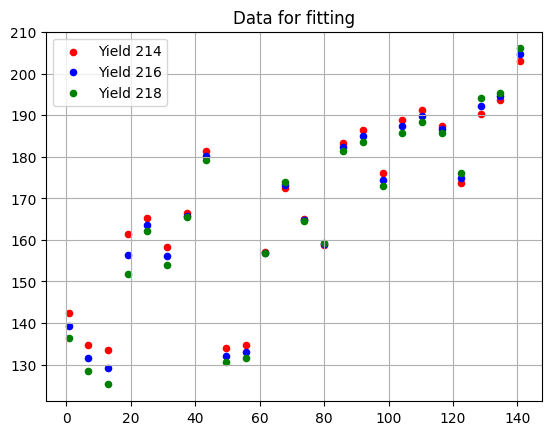

In [4]:
import pandas

df214 = df = pandas.read_csv("Example1SmoothHarvestStrip214.csv")
df216 = df = pandas.read_csv("Example1SmoothHarvestStrip216.csv")
df218 = df = pandas.read_csv("Example1SmoothHarvestStrip218.csv")

import matplotlib.pyplot

matplotlib.pyplot.scatter(df214['Northing'], df214['Yield'], s=20, color="red", label="Yield 214")
matplotlib.pyplot.scatter(df216['Northing'], df216['Yield'], s=20, color="blue", label="Yield 216")
matplotlib.pyplot.scatter(df218['Northing'], df218['Yield'], s=20, color="green", label="Yield 218")
matplotlib.pyplot.title("Data for fitting")
matplotlib.pyplot.legend(); matplotlib.pyplot.grid(True)
matplotlib.pyplot.show()

As we see, the data are very similar, so we should expect similar smoothing curves. But in `mgcv`, that is not the case.

To attempt to duplicate the `mgcv` algorithm, we first need to define a matrix $X$ that consist of a column all with value 1 for the intercept, and dummy encoding column of 0 or 1 depending the the product, then a number $df$ of colums encoding the spline bases for the smoother.

We first define an $X$ matrix that is only the spline basis. We start with $b$-splines. With `mgcv`, $b$-splines fit well to curves 214 and 216 but fit a straight line (with a correspondng large $\lambda$) for curve 218.

The first step to defining a spline bases is to determine the placement of knots. We space the knots uniformly for a $b$-spline bases. 

We start with the curve for 214, and for simplicitly will copy the independent variable `Northing` to an array denoted `x`.

For splines, we default to `degree=3` to produce cubic splines, and will work with degrees of freedom of 9. This should correspond to 6 internal knots.

In [9]:
import numpy

n_knots = 9
degree = 3

x = numpy.asarray(df214['Northing'])
xmin, xmax = x.min(), x.max()
n_internal = n_knots - degree + 2
internal = numpy.linspace(xmin, xmax, n_internal)
knots = numpy.concatenate(([xmin]*degree, internal, [xmax]*degree))
knots

array([  0.78307296,   0.78307296,   0.78307296,   0.78307296,
        20.76851087,  40.75394879,  60.7393867 ,  80.72482462,
       100.71026253, 120.69570045, 140.68113836, 140.68113836,
       140.68113836, 140.68113836])

Now we need to generate basis functions over the knots to generate our first design matrix $\mathbf{X}$. We use the `scipy.interpolate` function `BSpline`

In [10]:
import scipy.interpolate
n_basis = len(knots) - degree - 1
X = numpy.zeros((len(x), n_basis))
for i in range(n_basis):
    c = numpy.zeros(n_basis)
    c[i] = 1
    spline = scipy.interpolate.BSpline(knots, c, degree, extrapolate=False)
    X[:, i] = spline(x)

Plot the bases to see if they look reasonable:

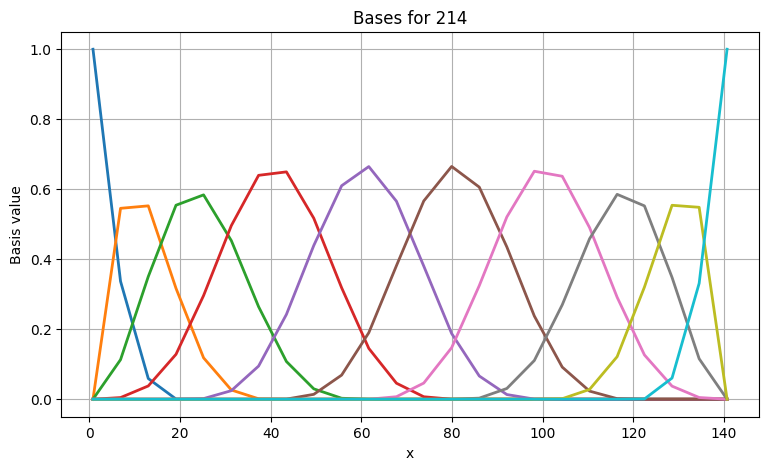

In [11]:
matplotlib.pyplot.figure(figsize=(9,5))
for j in range(X.shape[1]):
    matplotlib.pyplot.plot(x, X[:,j], lw=2)
matplotlib.pyplot.title("Bases for 214")
matplotlib.pyplot.xlabel("x"); matplotlib.pyplot.ylabel("Basis value")
matplotlib.pyplot.grid(True)
matplotlib.pyplot.show()

We also might examine the values in $\mathbf{X}$ for comparison with `mgcv`

In [12]:
X

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [3.36834070e-01, 5.45457916e-01, 1.13015435e-01, 4.69257910e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [5.90657848e-02, 5.52468218e-01, 3.50532344e-01, 3.79336531e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [5.83536428e-04, 3.16889597e-01, 5.54248261e-01, 1.28278606e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.18264266e-01, 5.83867558e-01, 2.96073594e-01,
        1.79458265e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.63910078e-02, 4.53075311e-01, 4.96085986e-01,
   

So the bases look reasonable. We'll continue on with just the bases smoothers in $\mathbf{X}$, then later add in the intercept and product dummy encoding.

Now we need consider the algorithm to produce a set coefficients fitting the bases to the data. Without going into the detail of the derivation, we will be considering penalized iteratively reweighted least squares (P-IRLS). 

Using ordinary least squares, we minimize find $\beta$ to minimize $\lVert \mathbf{y} - \mathbf{X} \beta \rVert$
With ordinarly IRLS, we consider the solution to $widehat{\beta} = 

In [14]:
y = numpy.asarray(df214['Yield'])
XtX = numpy.matmul(X.transpose(), X)
Xty = numpy.matmul(X.transpose(), y)
#XtX
#Xty

HatBeta = numpy.matmul(numpy.linalg.inv(XtX) , Xty)

print(HatBeta)

[143.11580378 114.12964291 177.66147783 161.74409772 140.16500369
 178.31425348 188.2356379  182.14707365 187.27709181 203.94019929]


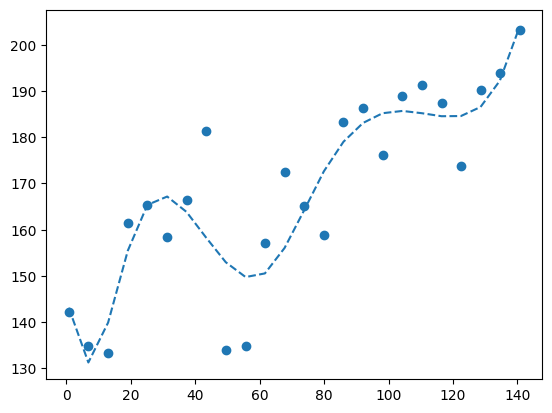

In [ ]:
HatY = numpy.matmul(X, HatBeta)
matplotlib.pyplot.figure().clear()
matplotlib.pyplot.scatter(x, y)
matplotlib.pyplot.plot(x, HatY, '--')
matplotlib.pyplot.show()

In [ ]:
"""
===========================================================
Manual Generalized Additive Model (GAM) Framework
===========================================================
Author: Patrick Baghdasarian
Description:
    - Loads yield data from CSV
    - Builds spline basis manually and with Patsy
    - Fits penalized GAMs (shared & by-Product smooths)
    - Captures iterative matrices (W, X'WX, penalized)
    - Generates PDF diagnostics
    - Exposes all X, S, W matrices for later investigation
===========================================================
"""

# ============================================================
# Imports and Dependencies
# ============================================================
import os, json
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import cond, LinAlgError
from scipy.interpolate import BSpline
from patsy import dmatrix

# Auto-install reportlab if not present
try:
    from reportlab.lib.pagesizes import letter
    from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
    from reportlab.lib.styles import getSampleStyleSheet
except ImportError:
    os.system('pip install reportlab')
    from reportlab.lib.pagesizes import letter
    from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
    from reportlab.lib.styles import getSampleStyleSheet

In [ ]:
# ============================================================
# 1. Load Data
# ============================================================
def load_yield_data(*filepaths):
    dfs = []
    for f in filepaths:
        print(f"\nLoading {f} ...")
        df = pd.read_csv(f)
        dfs.append(df)
    data = pd.concat(dfs, ignore_index=True)

    print("\n✅ Combined dataset shape:", data.shape)
    print("\n📋 Columns:", list(data.columns))
    with pd.option_context("display.max_columns", None):
        print("\n📊 Descriptive statistics:\n", data.describe(include='all'))

    if {'Yield', 'Product'}.issubset(data.columns):
        print("\n📦 Mean Yield by Product:\n", data.groupby('Product', dropna=False)['Yield'].mean())
    return data


In [ ]:
# ============================================================
# 2. Manual vs Patsy Spline Bases
# ============================================================
def manual_bspline_basis(x, n_knots=10, degree=3):
    """Manual open-uniform B-spline basis construction."""
    x = np.asarray(x)
    xmin, xmax = x.min(), x.max()
    n_internal = n_knots - degree + 2
    internal = np.linspace(xmin, xmax, n_internal)
    knots = np.concatenate(([xmin]*degree, internal, [xmax]*degree))
    n_basis = len(knots) - degree - 1
    X = np.zeros((len(x), n_basis))
    for i in range(n_basis):
        c = np.zeros(n_basis)
        c[i] = 1
        spline = BSpline(knots, c, degree, extrapolate=False)
        X[:, i] = spline(x)
    return X, knots

def second_diff_penalty(n_coef):
    """Discrete second-difference penalty matrix."""
    if n_coef < 3: return np.zeros((n_coef, n_coef))
    D2 = np.diff(np.eye(n_coef), n=2, axis=0)
    return D2.T @ D2

def patsy_bspline_basis(x, df=10, degree=3, include_intercept=False):
    """Patsy spline basis construction."""
    X = np.asarray(dmatrix(
    f"0 + bs(x, df={df}, degree={degree}, include_intercept={str(include_intercept)})",
    {"x": x}, return_type='dataframe'
    ))

    S = second_diff_penalty(X.shape[1])
    return X, S

def plot_bases(x, X, title):
    plt.figure(figsize=(9,5))
    for j in range(X.shape[1]):
        plt.plot(x, X[:,j], lw=2)
    plt.title(title)
    plt.xlabel("x"); plt.ylabel("Basis value")
    plt.grid(True)
    plt.show()

In [ ]:
# ============================================================
# 3. GLM Family Specifications
# ============================================================
def family_spec(family):
    if family == "gaussian":
        return {"link": lambda mu: mu, "inv": lambda eta: eta,
                "var": lambda mu: np.ones_like(mu), "gprime": lambda mu: np.ones_like(mu),
                "mu_clip": lambda mu: mu}
    elif family == "poisson":
        return {"link": np.log, "inv": np.exp,
                "var": lambda mu: mu, "gprime": lambda mu: 1/np.maximum(mu,1e-12),
                "mu_clip": lambda mu: np.maximum(mu,1e-12)}
    elif family == "binomial":
        inv = lambda eta: 1/(1+np.exp(-eta))
        return {"link": lambda mu: np.log(mu/(1-mu)), "inv": inv,
                "var": lambda mu: mu*(1-mu), "gprime": lambda mu: 1/np.maximum(mu*(1-mu),1e-12),
                "mu_clip": lambda mu: np.clip(mu,1e-8,1-1e-8)}
    else:
        raise ValueError("Unsupported family.")

In [ ]:
# ============================================================
# 4. Penalized IRLS with Matrix Capture
# ============================================================
def penalized_irls(y, X, S, lam=10, family="gaussian", max_iter=40, tol=1e-6,
                   eps=1e-8, capture=True):
    fam = family_spec(family)
    n, p = X.shape
    beta = np.zeros(p)
    eta = X @ beta
    mu = fam["inv"](eta)
    mu = fam["mu_clip"](mu)

    trace = {"W":[], "XTWX":[], "Penalized":[],
             "Cond_XWX":[], "Cond_S":[], "Cond_Penalized":[], "Beta":[]}

    for it in range(max_iter):
        gprime_mu = fam["gprime"](mu)
        var_mu = fam["var"](mu)
        z = eta + (y - mu) * gprime_mu
        w_diag = 1.0 / np.maximum(var_mu * (gprime_mu**2), 1e-12)
        W = np.diag(w_diag)

        XTWX = X.T @ W @ X
        Penalized = XTWX + lam*S + eps*np.eye(p)
        cond_XWX, cond_S, cond_P = cond(XTWX), cond(S), cond(Penalized)
        trace["Cond_XWX"].append(cond_XWX)
        trace["Cond_S"].append(cond_S)
        trace["Cond_Penalized"].append(cond_P)
        trace["W"].append(W.copy())
        trace["XTWX"].append(XTWX.copy())
        trace["Penalized"].append(Penalized.copy())
        trace["Beta"].append(beta.copy())

        b = X.T @ W @ z
        try:
            beta_new = np.linalg.solve(Penalized, b)
        except LinAlgError:
            beta_new = np.linalg.pinv(Penalized) @ b
        delta = np.linalg.norm(beta_new - beta)
        beta = beta_new
        eta = X @ beta
        mu = fam["inv"](eta)
        mu = fam["mu_clip"](mu)
        if delta < tol:
            print(f"Converged at iteration {it}")
            break
    return beta, mu, np.diag(W), trace, None


In [ ]:
# ============================================================
# 5. Combined GAM Fitting Routine
# ============================================================
def fit_gam(data, family="gaussian", lam=100, df=10, degree=3):
    x = data["Northing"].values
    y = data["Yield"].values
    print(f"\nBuilding both Manual and Patsy spline bases (df={df}, degree={degree})")

    # --- Build spline bases ---
    # Manual B-spline
    X_manual, knots_manual = manual_bspline_basis(x, n_knots=df, degree=degree)
    S_manual = second_diff_penalty(X_manual.shape[1])

    # Patsy B-spline
    X_patsy, S_patsy = patsy_bspline_basis(x, df=df, degree=degree)

    # --- Condition diagnostics ---
    print("\nCondition numbers:")
    print(f" cond(X_manual) = {cond(X_manual):.3e}")
    print(f" cond(X_patsy)  = {cond(X_patsy):.3e}")

    plot_bases(x, X_manual, "Manual B-spline Basis Functions")
    plot_bases(x, X_patsy, "Patsy B-spline Basis Functions")

    # ============================================================
    # Fit both using IRLS (penalized least squares)
    # ============================================================
    print("\n--- Fitting Manual Basis GAM ---")
    beta_m, mu_m, w_diag_m, trace_m, save_path_m = penalized_irls(
        y, X_manual, S_manual, lam=lam, family=family
    )

    print("\n--- Fitting Patsy Basis GAM ---")
    beta_p, mu_p, w_diag_p, trace_p, save_path_p = penalized_irls(
        y, X_patsy, S_patsy, lam=lam, family=family
    )

    # ============================================================
    # Visual comparison of smooth fits
    # ============================================================
    plt.figure(figsize=(9,5))
    plt.scatter(x, y, color='gray', s=20, label="Observed")
    plt.plot(x, mu_m, 'r', lw=2, label="Manual GAM fit")
    plt.plot(x, mu_p, 'b--', lw=2, label="Patsy GAM fit")
    plt.xlabel("Northing"); plt.ylabel("Yield")
    plt.legend(); plt.title("Manual vs Patsy GAM Fits")
    plt.grid(True)
    plt.show()

    # ============================================================
    # Store all objects for later diagnostics and comparison
    # ============================================================
    gam_data = {
        "x": x, "y": y,
        "X_manual": X_manual, "S_manual": S_manual, "knots_manual": knots_manual,
        "X_patsy": X_patsy, "S_patsy": S_patsy,
        "beta_manual": beta_m, "beta_patsy": beta_p,
        "mu_manual": mu_m, "mu_patsy": mu_p,
        "w_diag_manual": w_diag_m, "w_diag_patsy": w_diag_p,
        "trace_manual": trace_m, "trace_patsy": trace_p,
        "save_path_manual": save_path_m, "save_path_patsy": save_path_p
    }

    print("✅ Stored all matrices, weights, and fit results in `gam_data`.")
    return gam_data


In [ ]:
# ============================================================
# 6. Utility: Condition Number Comparison
# ============================================================
def compare_condition_numbers(trace_m, trace_p):
    plt.figure(figsize=(8,5))
    plt.plot(trace_m["Cond_Penalized"], 'r', label="Manual")
    plt.plot(trace_p["Cond_Penalized"], 'b', label="Patsy")
    plt.yscale('log')
    plt.xlabel("Iteration"); plt.ylabel("Condition Number (log)")
    plt.legend(); plt.title("Condition Number Evolution")
    plt.grid(True); plt.show()

In [ ]:
# ============================================================
# 7. Execution Example
# ============================================================
if __name__ == "__main__":
    data = load_yield_data("Example1SmoothHarvestStrip214.csv")
    gam_data = fit_gam(data, family="gaussian", lam=100, df=10, degree=3)
    compare_condition_numbers(gam_data["trace_manual"], gam_data["trace_patsy"])

In [ ]:
# ============================================================
# Compatibility Helper for GCV module
# ============================================================
from patsy import dmatrix
import numpy as np

def build_spline_basis(x, spline_type="cr", df=12, degree=3, include_intercept=False):
    """
    Construct a spline basis and corresponding roughness penalty matrix.
    
    Parameters
    ----------
    x : array-like
        The predictor variable (1D numeric array).
    spline_type : {"bs", "cr"}
        Type of spline basis:
        - "bs": standard B-spline basis (raw B-splines)
        - "cr": cubic regression spline (matches mgcv::s(bs="cr"))
    df : int
        Degrees of freedom for spline basis.
    degree : int
        Degree of the spline (default 3 = cubic).
    include_intercept : bool
        Whether to include an intercept term in the basis.
    
    Returns
    -------
    X : ndarray (n x k)
        Design matrix for spline basis.
    S : ndarray (k x k)
        Penalty matrix approximating second derivative penalty.
    spline_name : str
        Label for the type of spline.
    """

    x = np.asarray(x, dtype=float)

    # --- Select spline basis via Patsy ---
    if spline_type == "bs":
        # Capitalize Boolean explicitly to avoid "name 'false' is not defined"
        include_str = "True" if include_intercept else "False"
        X = np.asarray(
            dmatrix(
                f"bs(x, df={df}, degree={degree}, include_intercept={include_str})",
                {"x": x},
            )
        )

    elif spline_type == "cr":
        # Cubic regression spline basis (mgcv equivalent)
        X = np.asarray(dmatrix(f"cr(x, df={df})", {"x": x}))

    else:
        raise ValueError("spline_type must be 'bs' or 'cr'.")

    # --- Build a simple roughness penalty (2nd-order finite difference) ---
    k = X.shape[1]
    D = np.diff(np.eye(k), n=2, axis=0)
    S = D.T @ D

    spline_name = f"{spline_type}(df={df}, degree={degree})"
    return X, S, spline_name


In [ ]:
# ============================================================
# 4C. Full-IRLS GCV (Gaussian / Poisson / Binomial)
# ============================================================
from numpy.linalg import solve, inv, LinAlgError

def _glm_deviance(y, mu, family, eps=1e-12):
    """GLM deviance (up to additive constants) for scoring GCV across families."""
    y = np.asarray(y, dtype=float)
    mu = np.asarray(mu, dtype=float)
    mu = np.clip(mu, eps, 1 - eps) if family == "binomial" else np.maximum(mu, eps)

    if family == "gaussian":
        # Weighted RSS is handled by W; here deviance ~ unweighted RSS
        return float(np.sum((y - mu)**2))

    elif family == "poisson":
        # 2 * sum( y log(y/mu) - (y - mu) ), with 0 log(0)=0 convention
        term = np.zeros_like(y)
        mask = y > 0
        term[mask] = y[mask] * (np.log(y[mask] / mu[mask]))
        return float(2.0 * np.sum(term - (y - mu)))

    elif family == "binomial":
        # Bernoulli deviance: 2 * sum( y log(y/mu) + (1-y) log((1-y)/(1-mu)) )
        t1 = np.zeros_like(y)
        t2 = np.zeros_like(y)
        mask1 = (y > 0)
        mask2 = (y < 1)
        t1[mask1] = y[mask1] * np.log(y[mask1] / mu[mask1])
        t2[mask2] = (1 - y[mask2]) * np.log((1 - y[mask2]) / (1 - mu[mask2]))
        return float(2.0 * np.sum(t1 + t2))

    else:
        raise ValueError("Unsupported family for deviance.")

def _trace_hat_edf(X, w_diag, S, lam, eps=1e-8):
    """
    edf = tr( (X' W X) (X' W X + lam S + eps I)^{-1} )
    Avoids forming n×n hat matrix; uses p×p solve.
    """
    X = np.asarray(X, dtype=float)
    w_diag = np.asarray(w_diag, dtype=float)
    S = np.asarray(S, dtype=float)
    p = X.shape[1]
    XtWX = X.T @ (w_diag[:, None] * X)
    P = XtWX + lam * S + eps * np.eye(p)

    try:
        # Solve P^{-1} XtWX via linear solves (more stable than explicit inverse)
        C = solve(P, XtWX)
    except LinAlgError:
        C = np.linalg.pinv(P) @ XtWX

    return float(np.trace(C)), XtWX, P

def select_lambda_gcv_glm(
    y, X, S, family="gaussian",
    lam_grid=None, max_iter=50, tol=1e-6, eps=1e-8, verbose=True
):
    """
    Full IRLS per-λ, then GCV score with GLM deviance and edf = tr(H).

    GCV(λ) = D(λ) / (n - edf(λ))^2      (common working form)
    For Gaussian, D reduces to RSS; for Poisson/Binomial it is GLM deviance.

    Returns
    -------
    lam_opt, gcv_scores, lam_grid, records
      where records[i] = dict(lam, dev, edf, trA, condP, beta, mu)
    """
    if lam_grid is None:
        lam_grid = np.logspace(-4, 6, 35)

    n = len(y)
    y = np.asarray(y, dtype=float)
    records = []
    gcv_scores = []

    # Warm-start across the grid
    beta0 = None

    for lam in lam_grid:
        # Run IRLS at this lambda
        # (Warm-start by injecting beta0 if you extend penalized_irls to accept it)
        beta, mu, w_diag, trace, _ = penalized_irls(
        y=y, X=X, S=S, lam=lam, family=family,
        max_iter=max_iter, tol=tol, eps=eps,
        capture=False  # speed
        )

        beta0 = beta  # keep for potential future extension

        # Effective df via tr( XtWX * P^{-1} )
        edf, XtWX, P = _trace_hat_edf(X, w_diag, S, lam, eps=eps)

        # Deviance (family-appropriate)
        dev = _glm_deviance(y, mu, family)

        # GCV score
        denom = (n - edf)
        gcv = float(dev / (denom**2 + eps))

        # Condition number of penalized system
        try:
            condP = float(cond(P))
        except LinAlgError:
            condP = np.inf

        records.append({
            "lam": float(lam),
            "dev": float(dev),
            "edf": float(edf),
            "gcv": float(gcv),
            "condP": condP,
            "beta": beta.copy(),
            "mu": mu.copy(),
        })
        gcv_scores.append(gcv)

        if verbose:
            print(f"λ={lam:9.3e}  GCV={gcv:12.5f}  dev={dev:12.5f}  "
                  f"edf={edf:8.3f}  cond(P)={condP:9.3e}")

    idx = int(np.argmin(gcv_scores))
    lam_opt = float(lam_grid[idx])
    if verbose:
        print(f"\n✅ Optimal λ (full-IRLS GCV) = {lam_opt:.3e}")
    return lam_opt, gcv_scores, lam_grid, records

def fit_gam_with_gcv_glm(
    data, spline_type="bs", family="gaussian", df=12, degree=3,
    lam_grid=None, max_iter=50, tol=1e-6
):
    """
    Build basis + penalty (with unpenalized intercept), select λ via full-IRLS GCV,
    then refit once at λ* to return final (beta, mu, trace, lam_opt).
    """
    x = data["Northing"].values.astype(float)
    y = data["Yield"].values.astype(float)

    # Build spline basis using your existing helper
    X_smooth, S, spline_name = build_spline_basis(x, spline_type=spline_type, df=df, degree=degree)
    n = len(y)
    intercept = np.ones((n, 1))
    X = np.hstack([intercept, X_smooth])
    S = np.block([
        [np.zeros((1,1)),                np.zeros((1, S.shape[1]))],
        [np.zeros((S.shape[0], 1)),      S]
    ])

    lam_opt, gcv_scores, lam_grid, records = select_lambda_gcv_glm(
        y, X, S, family=family, lam_grid=lam_grid, max_iter=max_iter, tol=tol, verbose=True
    )

    # Final refit at λ*
    beta, mu, w_diag, trace, save_path = penalized_irls(
        y=y, X=X, S=S, lam=lam_opt, family=family,
        max_iter=max_iter, tol=tol, capture=True
    )

    return {
        "x": x, "y": y, "X": X, "S": S, "spline_name": spline_name,
        "beta": beta, "mu": mu, "trace": trace, "w_diag": w_diag,
        "lam_opt": lam_opt, "gcv_scores": gcv_scores, "lam_grid": lam_grid,
        "gcv_records": records
    }

In [ ]:
data = load_yield_data("Example1SmoothHarvestStrip214.csv")


In [ ]:
data = load_yield_data("Example1SmoothHarvestStrip218.csv")

res = fit_gam_with_gcv_glm(
    data,
    spline_type="bs",       # or "manual"
    family="gaussian",      # "poisson" or "binomial" also supported
    df=12, degree=3,
    lam_grid=np.logspace(-4, 6, 35)
)


In [ ]:
# 1) Auto-select λ with full-IRLS GCV and refit once at λ*
res = fit_gam_with_gcv_glm(
    data,
    spline_type="bs",        # or "cr"
    family="gaussian",        # "gaussian", "poisson", "binomial"
    df=12, degree=3,
    lam_grid=np.logspace(-4, 6, 35)
)

# 2) Inspect the chosen λ and edf progression
print("λ* =", res["lam_opt"])
plt.semilogx(res["lam_grid"], res["gcv_scores"], 'o-')
plt.xlabel("λ"); plt.ylabel("GCV"); plt.title("Full-IRLS GCV"); plt.show()

# 3) Compare to mgcv (if you've exported gam_compare.csv and generated mgcv_yhat.csv)
#    (See earlier steps in our thread for the mgcv/R workflow.)


In [ ]:
# =========================
# Comparisons: pyGAM
# =========================
def compare_with_pygam(x, y, lam=100.0, family="gaussian", spline_terms=10, plot=True):
    """
    Fit a comparable GAM with pyGAM and compare fitted values.
    """
    try:
        import pygam
    except ImportError:
        os.system('pip install pygam')
        import pygam

    # family mapping
    fam_map = {
        "gaussian": pygam.GammaDist() if False else pygam.LinearGAM,  # use LinearGAM for Gaussian
        "poisson": pygam.PoissonGAM,
        "binomial": pygam.LogisticGAM
    }
    if family not in fam_map:
        raise ValueError("Unsupported family for pyGAM comparison.")

    # Build model
    if family == "gaussian":
        gam = pygam.LinearGAM(pygam.s(0, n_splines=spline_terms)).fit(x.reshape(-1,1), y)
    elif family == "poisson":
        gam = pygam.PoissonGAM(pygam.s(0, n_splines=spline_terms)).fit(x.reshape(-1,1), y)
    else:
        gam = pygam.LogisticGAM(pygam.s(0, n_splines=spline_terms)).fit(x.reshape(-1,1), y)

    yhat = gam.predict(x.reshape(-1,1))
    rmse = float(np.sqrt(np.mean((y - yhat)**2)))
    if plot:
        plt.figure(figsize=(9,5))
        plt.scatter(x, y, s=20, color="gray", label="Observed")
        plt.plot(x, yhat, "k--", lw=2, label="pyGAM fit")
        plt.title("pyGAM comparison")
        plt.legend(); plt.grid(True); plt.show()
    return {"pygam_rmse": rmse, "pygam_fitted": yhat, "pygam_model": gam}


In [ ]:
# =========================
# Comparisons: R mgcv via rpy2
# =========================
def compare_with_mgcv_via_rpy2(x, y, k=10, family="gaussian", plot=True):
    """
    Requires: R installed, mgcv installed in R, and rpy2 in Python.
    Formula: y ~ s(x, k=k, bs='cr')
    """
    try:
        import rpy2.robjects as ro
        from rpy2.robjects import numpy2ri
        numpy2ri.activate()
    except Exception as e:
        print("rpy2 is not available or R not installed. Falling back to CSV handoff.")
        return None

    ro.r("suppressPackageStartupMessages(library(mgcv))")
    r = ro.r

    r.assign("x", np.asarray(x))
    r.assign("y", np.asarray(y))
    r.assign("kval", int(k))

    if family == "gaussian":
        fam = "gaussian"
    elif family == "poisson":
        fam = "poisson"
    elif family == "binomial":
        fam = "binomial"
    else:
        raise ValueError("Unsupported family for mgcv.")

    r(f"""
        fit <- gam(y ~ s(x, k=kval, bs='cr'), family={fam}())
        yhat <- fitted(fit)
    """)
    yhat = np.array(r("yhat"))
    rmse = float(np.sqrt(np.mean((y - yhat)**2)))

    if plot:
        plt.figure(figsize=(9,5))
        plt.scatter(x, y, s=20, color="gray", label="Observed")
        plt.plot(x, yhat, "g", lw=2, label="mgcv fit (R)")
        plt.title("mgcv (R) comparison")
        plt.legend(); plt.grid(True); plt.show()

    return {"mgcv_rmse": rmse, "mgcv_fitted": yhat}


In [ ]:
# Export your data to CSV for R mgcv comparison
pd.DataFrame({"x": gam_data["x"], "y": gam_data["y"]}).to_csv("gam_compare.csv", index=False)
print("Saved gam_compare.csv for mgcv verification.")


In [ ]:
import numpy as np
import pandas as pd
yhat_mgcv = pd.read_csv("mgcv_yhat.csv")["yhat"].to_numpy()
rmse_mgcv = np.sqrt(np.mean((gam_data["y"] - yhat_mgcv)**2))
print(f"mgcv RMSE vs Manual/Patsy GAM: {rmse_mgcv:.4f}")


In [ ]:
# pin install rpy2

In [ ]:
# from rpy2.robjects import r

# # Try loading mgcv
# r('library(mgcv)')

# # Check its version (optional)
# r('print(packageVersion("mgcv"))')

# # If it's not installed yet, run this ONCE:
# r('install.packages("mgcv")')


In [ ]:
# import rpy2
# print("rpy2 version:", rpy2.__version__)

In [ ]:
# import importlib.metadata
# print(importlib.metadata.version("rpy2"))


In [ ]:
# from rpy2.robjects import r
# print("R version:", r("R.version.string")[0])


In [ ]:
# import os
# os.environ["R_HOME"] = "C:\\Program Files\\R\\R-4.5.1"
# compare_with_mgcv_via_rpy2(res["x"], res["y"], k=12, family="gaussian", plot=True)



In [ ]:
def compare_with_mgcv_via_rpy2(x, y, k=10, family="gaussian", plot=True):
    """
    Direct Python↔R mgcv comparison using updated rpy2 API (>=3.5).
    Compatible with R 4.5+ and rpy2 3.6+.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import os

    # --- R environment paths ---
    os.environ["R_HOME"] = r"C:\Program Files\R\R-4.5.1"
    os.environ["R_USER"] = os.getenv("USERPROFILE", "")

    print("🔍 Checking R and mgcv connectivity...")

    try:
        import rpy2.robjects as ro
        from rpy2.robjects import conversion, default_converter, numpy2ri
        from contextlib import contextmanager

        # --- Context-aware conversion ---
        @contextmanager
        def rpy2_numpy_context():
            with conversion.localconverter(
                default_converter + numpy2ri.converter
            ):
                yield

        r = ro.r
        with rpy2_numpy_context():
            # Load mgcv
            r('suppressPackageStartupMessages(library(mgcv))')
            r('cat("✅ mgcv loaded successfully in R.\\n")')

            # Send data
            r.assign("x", np.asarray(x))
            r.assign("y", np.asarray(y))
            r.assign("kval", int(k))

            # Choose family
            if family == "gaussian":
                fam = "gaussian"
            elif family == "poisson":
                fam = "poisson"
            elif family == "binomial":
                fam = "binomial"
            else:
                raise ValueError("Unsupported family for mgcv.")

            print("⚙️  Running mgcv::gam(y ~ s(x, k=kval, bs='cr')) ...")
            r(f"""
                fit <- gam(y ~ s(x, k=kval, bs='cr'), family={fam}())
                yhat <- fitted(fit)
                cat("Effective degrees of freedom:", sum(fit$edf), "\\n")
            """)
            yhat = np.array(r("yhat"))
            rmse = float(np.sqrt(np.mean((y - yhat)**2)))

        # --- Plot results ---
        if plot:
            plt.figure(figsize=(9,5))
            plt.scatter(x, y, s=20, color="gray", label="Observed")
            plt.plot(x, yhat, "g", lw=2, label="mgcv fit (R)")
            plt.title("mgcv (R) comparison via rpy2 (updated API)")
            plt.legend(); plt.grid(True)
            plt.show()

        print(f"✅ mgcv RMSE vs observed: {rmse:.4f}")
        return {"mgcv_rmse": rmse, "mgcv_fitted": yhat}

    except Exception as e:
        print("❌ rpy2 failed to initialize R interface.")
        print("Error:", e)
        print("Falling back to CSV handoff for mgcv.")
        return None


In [ ]:
# compare_with_mgcv_via_rpy2(
#     res["x"],
#     res["y"],
#     k=12,
#     family="gaussian",
#     plot=True
# )


In [ ]:
import importlib.metadata
print("rpy2 version:", importlib.metadata.version("rpy2"))

from rpy2.robjects import r
print("R version:", r("R.version.string")[0])


# 2. Set environment (only needed once)
import os
os.environ["R_HOME"] = r"C:\Program Files\R\R-4.5.1"

# 3. Run your GAM comparison
res_mgcv = compare_with_mgcv_via_rpy2(
    res["x"],
    res["y"],
    k=12,
    family="gaussian",
    plot=True
)


In [ ]:
import importlib.metadata
print("rpy2 version:", importlib.metadata.version("rpy2"))

from rpy2.robjects import r
print("R version:", r("R.version.string")[0])

import os
os.environ["R_HOME"] = r"C:\\Program Files\\R\\R-4.5.1"


In [ ]:
# Example: reuse your existing fit
res = fit_gam_with_gcv_glm(
    data,
    spline_type="bs",
    family="gaussian",
    df=12, degree=3,
    lam_grid=np.logspace(-4, 6, 35)
)
print("λ* =", res["lam_opt"])


In [ ]:
def compare_with_mgcv_via_rpy2(x, y, k=12, family="gaussian", plot=True):
    """
    Compare Python penalized-IRLS GAM vs R mgcv::gam via rpy2.
    Exports mgcv_yhat.csv and returns both fits + RMSE.
    """
    import numpy as np, matplotlib.pyplot as plt, pandas as pd, os
    os.environ["R_HOME"] = r"C:\\Program Files\\R\\R-4.5.1"
    os.environ["R_USER"] = os.getenv("USERPROFILE", "")

    print("🔍 Checking R and mgcv connectivity...")

    try:
        import rpy2.robjects as ro
        from rpy2.robjects import conversion, default_converter, numpy2ri
        from contextlib import contextmanager

        @contextmanager
        def rpy2_numpy_context():
            with conversion.localconverter(default_converter + numpy2ri.converter):
                yield

        r = ro.r
        with rpy2_numpy_context():
            r('suppressPackageStartupMessages(library(mgcv))')
            r('cat("✅ mgcv loaded successfully in R.\\n")')

            r.assign("x", np.asarray(x))
            r.assign("y", np.asarray(y))
            r.assign("kval", int(k))

            if family not in ["gaussian", "poisson", "binomial"]:
                raise ValueError("Unsupported family for mgcv.")

            print(f"⚙️  Running mgcv::gam(y ~ s(x, k={k}, bs='cr'), family={family}) ...")
            r(f"""
                fit <- gam(y ~ s(x, k=kval, bs='cr'), family={family}())
                yhat <- fitted(fit)
                cat(sum(fit$edf), "degrees of freedom\\n")
            """)
            yhat = np.array(r("yhat"))
            rmse = float(np.sqrt(np.mean((y - yhat)**2)))
            pd.DataFrame({"x": x, "yhat_mgcv": yhat}).to_csv("mgcv_yhat.csv", index=False)

        if plot:
            plt.figure(figsize=(9,5))
            plt.scatter(x, y, s=20, color="gray", label="Observed")
            plt.plot(x, yhat, "g", lw=2, label="mgcv fit (R)")
            plt.title("R mgcv fit via rpy2 (updated API)")
            plt.legend(); plt.grid(True)
            plt.show()

        print(f"✅ mgcv RMSE vs observed: {rmse:.4f}")
        return {"mgcv_rmse": rmse, "mgcv_fitted": yhat}

    except Exception as e:
        print("❌ rpy2 failed to initialize R interface.")
        print("Error:", e)
        print("Falling back to CSV handoff for mgcv.")
        return None


In [ ]:
mgcv_res = compare_with_mgcv_via_rpy2(
    res["x"],
    res["y"],
    k=12,
    family="gaussian",
    plot=True
)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Reload R results
mgcv_df = pd.read_csv("mgcv_yhat.csv")

plt.figure(figsize=(9,5))
plt.scatter(res["x"], res["y"], s=20, color="gray", label="Observed")
plt.plot(res["x"], res["mu"], "r--", lw=2, label="Python IRLS GAM")
plt.plot(mgcv_df["x"], mgcv_df["yhat_mgcv"], "g", lw=2, label="R mgcv GAM")
plt.title("Python GAM vs R mgcv Comparison")
plt.legend(); plt.grid(True)
plt.show()

rmse_py = np.sqrt(np.mean((res["y"] - res["mu"])**2))
rmse_r = np.sqrt(np.mean((res["y"] - mgcv_df["yhat_mgcv"])**2))
print(f"Python GAM RMSE: {rmse_py:.4f} | R mgcv RMSE: {rmse_r:.4f}")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load mgcv fit ---
mgcv_df = pd.read_csv("mgcv_yhat.csv")

# --- Compute fits and residuals ---
comparison_df = pd.DataFrame({
    "x": res["x"],
    "y_observed": res["y"],
    "y_python_fit": res["mu"],
    "y_mgcv_fit": mgcv_df["yhat_mgcv"],
})

# Residual diagnostics
comparison_df["residual_python"] = comparison_df["y_observed"] - comparison_df["y_python_fit"]
comparison_df["residual_mgcv"] = comparison_df["y_observed"] - comparison_df["y_mgcv_fit"]

# --- RMSE ---
rmse_python = np.sqrt(np.mean(comparison_df["residual_python"] ** 2))
rmse_mgcv = np.sqrt(np.mean(comparison_df["residual_mgcv"] ** 2))

# --- Export ---
comparison_df.to_csv("gam_python_vs_mgcv_comparison.csv", index=False)

# --- Visualization ---
plt.figure(figsize=(9, 5))
plt.scatter(comparison_df["x"], comparison_df["y_observed"], s=25, color="gray", label="Observed")
plt.plot(comparison_df["x"], comparison_df["y_python_fit"], "r--", lw=2, label="Python IRLS GAM")
plt.plot(comparison_df["x"], comparison_df["y_mgcv_fit"], "g", lw=2, label="R mgcv GAM")
plt.title("Python GAM vs R mgcv (Fitted Curves)")
plt.legend(); plt.grid(True)
plt.show()

# --- Residual Plot ---
plt.figure(figsize=(9, 5))
plt.scatter(comparison_df["x"], comparison_df["residual_python"], color="red", alpha=0.6, label="Python residuals")
plt.scatter(comparison_df["x"], comparison_df["residual_mgcv"], color="green", alpha=0.6, label="R mgcv residuals")
plt.axhline(0, color="black", lw=1)
plt.title("Residuals Comparison (Python vs mgcv)")
plt.xlabel("x"); plt.ylabel("Residual"); plt.legend(); plt.grid(True)
plt.show()

# --- Summary output ---
summary = pd.DataFrame({
    "Model": ["Python GAM (IRLS)", "R mgcv"],
    "RMSE": [rmse_python, rmse_mgcv],
    "Mean Residual": [comparison_df["residual_python"].mean(), comparison_df["residual_mgcv"].mean()],
    "Std Residual": [comparison_df["residual_python"].std(), comparison_df["residual_mgcv"].std()],
})

print("✅ Model Performance Comparison:")
display(summary)
print("\n📁 Saved: gam_python_vs_mgcv_comparison.csv")


In [ ]:
import numpy as np
from patsy import dmatrix

# Example: load your predictor variable (replace this with your actual data column)
import pandas as pd
data = pd.read_csv("Example1SmoothHarvestStrip214.csv")

# Suppose your predictor is called 'Northing' or similar:
x = data["Northing"].values  # or whatever column name you used

# Now construct the spline basis with df=12 and cubic degree
X = np.asarray(
    dmatrix("bs(x, df=12, degree=3, include_intercept=False)", {"x": x})
)

print("Design matrix shape:", X.shape)
print(X[:5])


In [ ]:
from rpy2.robjects import r, conversion, default_converter
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import numpy2ri
import numpy as np

# Example numeric vector
x = np.linspace(0, 1, 50)
k = 12

# --- Load R mgcv ---
r('suppressPackageStartupMessages(library(mgcv))')

# --- Explicitly convert numpy arrays to R vectors ---
x_r = numpy2ri.py2rpy(x)
r.assign("x", x_r)
r.assign("kval", k)

# --- Conversion context for pulling back arrays ---
with localconverter(default_converter + numpy2ri.converter):
    r('B <- smoothCon(s(x, k=kval, bs="cr"), data=data.frame(x=x))[[1]]$X')
    r('S <- smoothCon(s(x, k=kval, bs="cr"), data=data.frame(x=x))[[1]]$S[[1]]')
    X_mgcv = np.array(r('B'))
    S_mgcv = np.array(r('S'))

print("Design matrix shape:", X_mgcv.shape)
print("Penalty matrix shape:", S_mgcv.shape)


In [ ]:
def extract_mgcv_basis(x, k=12, bs="cr"):
    from rpy2.robjects import r, conversion, default_converter
    from rpy2.robjects.conversion import localconverter
    from rpy2.robjects import numpy2ri
    import numpy as np

    r('suppressPackageStartupMessages(library(mgcv))')
    x_r = numpy2ri.py2rpy(np.asarray(x))
    r.assign("x", x_r)
    r.assign("kval", k)
    r.assign("bs_type", bs)

    with localconverter(default_converter + numpy2ri.converter):
        r('B <- smoothCon(s(x, k=kval, bs=bs_type), data=data.frame(x=x))[[1]]$X')
        r('S <- smoothCon(s(x, k=kval, bs=bs_type), data=data.frame(x=x))[[1]]$S[[1]]')
        X_mgcv = np.array(r('B'))
        S_mgcv = np.array(r('S'))
    return X_mgcv, S_mgcv


In [ ]:
X_mgcv, S_mgcv = extract_mgcv_basis(x, k=12)
print("Design matrix shape:", X_mgcv.shape)
print("Penalty matrix shape:", S_mgcv.shape)


In [ ]:
from patsy import dmatrix
import numpy as np

# --- Python cubic regression spline basis (same as mgcv bs="cr") ---
X_py = np.asarray(dmatrix("cr(x, df=12)", {"x": x}))
X_py = X_py[:, 1:]  # drop intercept column
print("Python design matrix:", X_py.shape)

# --- Normalize both bases for scale-invariant comparison ---
def normalize(M):
    return M / np.linalg.norm(M, axis=0, keepdims=True)

X_diff = np.linalg.norm(normalize(X_py) - normalize(X_mgcv))
print(f"‖Normalized difference between Python and mgcv bases‖ = {X_diff:.4e}")


In [ ]:
import numpy as np
from numpy.linalg import solve, LinAlgError
from sklearn.model_selection import KFold

def fit_fixed_lambda(
    x, y, lam, family="gaussian", df=12, degree=3, spline_type="cr",
    eps=1e-8, max_iter=50, tol=1e-6, return_internals=False
):
    # Build basis with unpenalized intercept (first column)
    X_smooth, S, _ = build_spline_basis(x, spline_type=spline_type, df=df, degree=degree)
    n = len(y)
    X = np.hstack([np.ones((n,1)), X_smooth])
    S = np.block([[np.zeros((1,1)),                 np.zeros((1, S.shape[1]))],
                  [np.zeros((S.shape[0],1)),       S]])

    beta, mu, w_diag, trace, _ = penalized_irls(
        y=y, X=X, S=S, lam=lam, family=family, max_iter=max_iter, tol=tol, eps=eps, capture=True
    )

    # algebraic checks
    XtWX = X.T @ (w_diag[:,None]*X)
    P = XtWX + lam*S + eps*np.eye(X.shape[1])
    z = (X @ beta) + (y - mu) * family_spec(family)["gprime"](mu)
    rhs = X.T @ (w_diag[:,None]*z)
    try:
        res = P @ beta - rhs
        normal_eq_relres = np.linalg.norm(res) / max(np.linalg.norm(rhs), eps)
    except Exception:
        normal_eq_relres = np.nan

    # edf
    try:
        C = solve(P, XtWX)
    except LinAlgError:
        C = np.linalg.pinv(P) @ XtWX
    edf = float(np.trace(C))

    out = {"beta": beta, "mu": mu, "edf": edf, "w_diag": w_diag,
           "normal_eq_relres": normal_eq_relres, "X": X, "S": S}
    return (out if return_internals else mu)

def kfold_cv_fixed_lambda(
    x, y, lam, family="gaussian", df=12, degree=3, spline_type="cr",
    K=5, shuffle=True, seed=1, metric="rmse"
):
    kf = KFold(n_splits=K, shuffle=shuffle, random_state=seed)
    scores = []
    for tr, te in kf.split(x):
        res_tr = fit_fixed_lambda(x[tr], y[tr], lam, family, df, degree, spline_type)
        # predict on test using fixed β from train
        Xs, S, _ = build_spline_basis(x[tr], spline_type, df, degree)
        Xt  = np.hstack([np.ones((len(tr),1)), Xs])
        # rebuild for test points using same basis constructor
        Xs_te, _, _ = build_spline_basis(x[te], spline_type, df, degree)
        Xt_te = np.hstack([np.ones((len(te),1)), Xs_te])

        # We need β from the training fit:
        out_tr = fit_fixed_lambda(x[tr], y[tr], lam, family, df, degree, spline_type, return_internals=True)
        beta = out_tr["beta"]
        yhat_te = Xt_te @ beta

        if metric == "rmse":
            s = float(np.sqrt(np.mean((y[te] - yhat_te)**2)))
        elif metric == "deviance":
            mu_te = yhat_te if family=="gaussian" else family_spec(family)["inv"](Xt_te @ beta)
            s = float(_glm_deviance(y[te], mu_te, family))
        else:
            raise ValueError("metric should be 'rmse' or 'deviance'")
        scores.append(s)

    return {"lam": lam, "K": K, "metric": metric, "scores": scores,
            "mean": float(np.mean(scores)), "std": float(np.std(scores))}


In [ ]:
x = data["Northing"].values.astype(float)
y = data["Yield"].values.astype(float)

# Example: test λ = 1
diag = kfold_cv_fixed_lambda(x, y, lam=1.0, family="gaussian", df=12, degree=3, spline_type="cr", K=5)
print(diag)


In [ ]:
lam_grid = np.logspace(-3, 3, 15)
results = []
for lam in lam_grid:
    cv = kfold_cv_fixed_lambda(x, y, lam=lam, family="gaussian", df=12, degree=3, spline_type="cr", K=5)
    results.append((lam, cv["mean"], cv["std"]))

import matplotlib.pyplot as plt
lams, means, stds = zip(*results)
plt.semilogx(lams, means, marker='o')
plt.fill_between(lams, np.array(means)-np.array(stds), np.array(means)+np.array(stds), alpha=0.2)
plt.xlabel("λ (fixed)")
plt.ylabel("Mean 5-fold RMSE")
plt.title("Cross-validated RMSE vs λ")
plt.show()


In [ ]:
lam_grid = np.logspace(-3, 5, 30)
edfs = []
for lam in lam_grid:
    res = fit_fixed_lambda(x, y, lam, return_internals=True)
    edfs.append(res["edf"])
plt.semilogx(lam_grid, edfs, marker="o")
plt.xlabel("λ"); plt.ylabel("Effective df")
plt.title("edf(λ) monotonicity check")
plt.show()


In [ ]:
from rpy2.robjects import r, conversion, default_converter, numpy2ri
from contextlib import contextmanager

@contextmanager
def rpy2_numpy_context():
    with conversion.localconverter(default_converter + numpy2ri.converter):
        yield

r('suppressPackageStartupMessages(library(mgcv))')


In [ ]:
def compare_with_mgcv_fixed_lambda(x, y, lam=1.0, k=12, bs="cr", family="gaussian", plot=True):
    """
    Compare Python IRLS GAM vs R mgcv::gam at a fixed lambda (sp=lam)
    using your verified rpy2 connection.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    print(f"Running mgcv::gam at λ={lam}")

    with rpy2_numpy_context():
        r.assign("x", np.asarray(x))
        r.assign("y", np.asarray(y))
        r.assign("lam", float(lam))
        r.assign("k", int(k))
        r.assign("bs", bs)
        r.assign("fam", family)

        r('''
            suppressPackageStartupMessages(library(mgcv))
            dat <- data.frame(x=x, y=y)
            fit <- gam(y ~ s(x, k=k, bs=bs), data=dat, sp=lam, family=fam)
            yhat <- fitted(fit)
            edf  <- sum(fit$edf)
        ''')

        yhat_r = np.array(r("yhat"))
        edf_r = float(r("edf")[0])

    # --- Python-side fit (you already have your IRLS)
    out_py = fit_fixed_lambda(x, y, lam=lam, family=family, df=k, degree=3,
                              spline_type=bs, return_internals=True)
    yhat_py = out_py["X"] @ out_py["beta"]
    edf_py = out_py["edf"]

    # --- Compare ---
    rmse = np.sqrt(np.mean((yhat_py - yhat_r)**2))
    print(f"✅ RMSE between Python and mgcv fits: {rmse:.3e}")
    print(f"EDF_Python = {edf_py:.3f}, EDF_mgcv = {edf_r:.3f}")

    # --- Plot overlay ---
    if plot:
        plt.figure(figsize=(8,5))
        plt.scatter(x, y, s=20, color='gray', label='Observed')
        plt.plot(x, yhat_py, 'r--', lw=2, label='Python IRLS GAM')
        plt.plot(x, yhat_r, 'g-', lw=2, label='R mgcv GAM')
        plt.title(f"GAM Comparison at λ={lam}")
        plt.legend(); plt.grid(True); plt.show()

    return {
        "rmse": rmse,
        "edf_py": edf_py,
        "edf_r": edf_r,
        "yhat_py": yhat_py,
        "yhat_r": yhat_r
    }


In [ ]:
# Extract from your previous result object or dataset
x = res["x"] if "x" in res else data["Northing"].values
y = res["y"] if "y" in res else data["Yield"].values

# Now call the mgcv comparison
res_cmp = compare_with_mgcv_fixed_lambda(
    x=x,
    y=y,
    lam=1.0,
    k=12,
    bs="cr",
    family="gaussian",
    plot=True
)
